# Document Segmentation

This module is designed to create functions to support the segmentation process and integrate with OCR and OWR models. The segmentation will be managed using the function designed in owr_segmentation.ipynb.

### Load Libraries and Other Packages

In [1]:
# do not run when we import this package as module
if __name__ == '__main__':
  # Connect Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
if __name__ == '__main__':
  ## Load all ipynb files from Google Drive to Colab environment
  import os
  import shutil

  def find_and_copy_files(src_folder, dest_folder, file_extension):
    for foldername, subfolders, filenames in os.walk(src_folder):
        for filename in filenames:
            if filename.endswith(file_extension):
                src_file = os.path.join(foldername, filename)
                dest_file = os.path.join(dest_folder, filename)
                try:
                    shutil.copy2(src_file, dest_file)  # Use shutil.copy if you don't need metadata
                    print(f"Copied: {src_file} to {dest_file}")
                except Exception as e:
                    print(f"Error copying {src_file}: {e}")

In [3]:
if __name__ == '__main__':
  src_folder = '/content/gdrive/MyDrive/OWR/source'
  dest_folder = '/content'
  file_extension = '.ipynb'

  # Call the function to find and copy files
  find_and_copy_files(src_folder, dest_folder, file_extension)

Copied: /content/gdrive/MyDrive/OWR/source/input_generator/owr_input_generator.ipynb to /content/owr_input_generator.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/owr_model_v2.ipynb to /content/owr_model_v2.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_classification.ipynb to /content/owr_preprocess_skew_CNN_classification.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_regression.ipynb to /content/owr_preprocess_skew_CNN_regression.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_cv.ipynb to /content/owr_preprocess_skew_cv.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_pre_skew_cv_base.ipynb to /content/owr_pre_skew_cv_base.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocessing.ipynb to /content/owr_preprocessing.ipynb


In [4]:
if __name__ == '__main__':
  from IPython.display import clear_output as cls
  !pip install import_ipynb
  import import_ipynb

  cls()

In [5]:
if __name__ == '__main__':
  # Import Colab Models
  import owr_preprocessing as BPP
  import owr_model_v2 as WM

importing Jupyter notebook from owr_preprocessing.ipynb
importing Jupyter notebook from owr_model_v2.ipynb


In [6]:
# Load Libraries
import os
import json
import random
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
import math
from datetime import datetime
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output as cls

from tensorflow import keras
import tensorflow as tf

In [7]:
# Global Parameters
CharHeight4Line = 6
#CharWidth4Line = 85
CharWidth4Line = 185

CharHeight = 4
CharWidth = 4

### Initial Segmentation to Tables and Textual Areas

In [8]:
def imgZoom(img):
  # Get the current size of the image
  current_height, current_width, _ = img.shape

  # Calculate the new size (3/2 times the current size)
  new_height = int(current_height * 3 / 2)
  new_width = int(current_width * 3 / 2)

  # Resize the image
  return cv2.resize(img, (new_width, new_height))

In [9]:
# The prerequisite for the function is a Binary image.
def getContours(img):

  # Define Kernel for Morphological Operations

  # Image width
  kernel_length = np.array(img).shape[1]//80

  # A verticle kernel of (1 x kernel_length)
  verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,kernel_length))

  # A horizontal kernel of (kernel_length x 1)
  hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))

  # A kernel of (3 x 3) ones
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))


  # Morphological operation to detect vertical lines from an image
  img_temp1 = cv2.erode(img, verticle_kernel, iterations=3)
  vertical_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

  # Morphological operation to detect horizontal lines from an image
  img_temp2 = cv2.erode(img, hori_kernel, iterations=3)
  horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)

  # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
  alpha = 0.5
  beta = 1.0 - alpha


  # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
  img_final_bin = cv2.addWeighted(vertical_lines_img, alpha, horizontal_lines_img, beta, 0.0)
  img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)

  (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  # Find contours for image, which will detect all the boxes
  contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  '''
  0 : Star [1,-1,-1,-1]
  … Next — Outer Square (1)
  … Previous — No Contour(-1)
  … Child — No Child (-1)
  … Parent — No Parent (-1)

  '''

  # Initialize lists to store outer rectangles and their child contours
  outer_rectangles = []
  child_contours = []

  # Iterate through the hierarchy to find outer rectangles and their children
  for i in range(len(contours)):

      if hierarchy[0][i][3] == 0:  # Check if the contour has no parent (i.e., it's an outer contour)
          # Calculate the bounding rectangle of the outer contour
          x, y, w, h = cv2.boundingRect(contours[i])
          outer_rectangles.append((x, y, x + w, y + h))

          # Find child contours of the outer contour
          children = []
          for j in range(len(contours)):
              if hierarchy[0][j][3] == i:  # Check if contour j is a child of contour i
                  child_contour = contours[j]
                  x, y, w, h = cv2.boundingRect(child_contour)
                  children.append((x, y, x + w, y + h))
          child_contours.append(children)

  # Sort the outer rectangles based on their top-left coordinates (y, x)
  outer_rectangles = sorted(outer_rectangles, key=lambda rect: (rect[1], rect[0]))

  # Sort the child contours based on their top-left coordinates (y, x)
  for i in range(len(child_contours)):
    child_contours[i] = sorted(child_contours[i], key=lambda rect: (rect[1], rect[0]))

  child_min_y = []
  for i in range(len(child_contours)):
    y_min = np.array(img).shape[0]
    for j in range(len(child_contours[i])):
      if y_min > child_contours[i][j][1]:
        y_min = child_contours[i][j][1]

    child_min_y.append((y_min, i))
  child_min_y = np.array(child_min_y)
  sorted_array = child_min_y[child_min_y[:, 0].argsort()]


  tempChild = []
  for i in range(len(sorted_array)):
    tempChild.append(child_contours[sorted_array[i][1]])

  child_contours = tempChild

  # Return the contours
  return outer_rectangles, child_contours

In [10]:
def getBinarized(OrgImg, Zoon=True):
  # Convert image to Grayscale
  GrayImg = BPP.set_grayscale(OrgImg)

  # Binarization
  BinaryImg = BPP.set_Adaptive_Binarization(GrayImg)

  return BinaryImg

In [11]:
''' Retuen Table from Image
    As per the CD template there are two tables
    1. Code and Course Title
    2. Assessments
    Input Parameter
    Extract:
      1 - Code and Course Title
      2 - Assessments
      -1 - Without Code, Course Title and Assessments
'''
def getTableImg(orgImg, outer_rectangles, extract=-1):

  orgImg = orgImg.copy()

  if extract == 1:
    x1, y1, x2,y2 = outer_rectangles[0]
    return orgImg[y1:y2, x1:x2]
  elif extract == 2:
    x1, y1, x2,y2 = outer_rectangles[1]
    return orgImg[y1:y2, x1:x2]
  else:
    for rect in outer_rectangles:
      x1, y1, x2, y2 = rect
      cv2.rectangle(orgImg, (x1, y1), (x2, y2), 0, thickness=cv2.FILLED)
    return orgImg



In [12]:
def imgCourseCode(img, outer_rectangles, child_contours):
  out_x1, out_y1, out_x2, out_y2 = outer_rectangles[0]
  child_x1, child_y1, child_x2, child_y2 = child_contours[0][0]

  x1 = child_x1 - out_x1
  y1 = child_y1 - out_y1
  x2 = child_x2 - out_x1
  y2 = child_y2 - out_y1

  img = img[y1:y2, x1:x2]

  return img

In [13]:
def imgCourseTitle(img, outer_rectangles, child_contours):
  out_x1, out_y1, out_x2, out_y2 = outer_rectangles[0]
  child_x1, child_y1, child_x2, child_y2 = child_contours[0][1]

  x1 = child_x1 - out_x1
  y1 = child_y1 - out_y1
  x2 = child_x2 - out_x1
  y2 = child_y2 - out_y1

  img = img[y1:y2, x1:x2]

  return img

In [14]:
def imgAssessments(img, outer_rectangles, child_contours, row):
  if row == 0:
    index = 0
  else:
    index = 0
    for j in range(row):
      index += 3

  out_x1, out_y1, out_x2, out_y2 = outer_rectangles[1]

  for i in range(3):
    child_x1, child_y1, child_x2, child_y2 = child_contours[1][index + i]

    x1 = child_x1 - out_x1
    y1 = child_y1 - out_y1
    x2 = child_x2 - out_x1
    y2 = child_y2 - out_y1

    if i == 0:
      method = img[y1:y2, x1:x2]
    elif i == 1:
      weight = img[y1:y2, x1:x2]
    else:
      learning = img[y1:y2, x1:x2]

  return method, weight, learning


In [15]:
def getLines(img):
  kernel = np.ones((CharHeight4Line, CharWidth4Line), np.uint8)
  dilated = cv2.dilate(img, kernel, iterations=1)

  #cv2_imshow(dilated)

  (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

  line_contours = []
  for line in sorted_contours_lines:
    x, y, w, h = cv2.boundingRect(line)
    line_contours.append((x, y, x + w, y + h))


  return line_contours

In [16]:
def getWords(img, lines, index):
  words_list = []
  kernel = np.ones((CharHeight,CharWidth), np.uint8)

  x = lines[index][0]
  y = lines[index][1]
  x_e = lines[index][2]
  y_e = lines[index][3]


  #print(x, y, x_e, y_e)
  img = img[y:y_e, x:x_e]
  #cv2_imshow(img)
  #print(img.shape)

  dilated = cv2.dilate(img, kernel, iterations = 1)

  # draw contours on each word
  (cnt, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])

  for word in sorted_contour_words:

    x2, y2, w2, h2 = cv2.boundingRect(word)
    words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])

  # Remove overlapping rectangles
  non_overlapping_coordinates = remove_overlapping(words_list)

  return non_overlapping_coordinates

In [17]:
def getCharacters(img, preprocess):
  if preprocess:
    # Define a kernel for dilation
    kernel = np.ones((1, 1), np.uint8)

    # Dilate the binary image to increase the black in the middle of characters
    dilated_image = cv2.dilate(img, kernel, iterations=2)

  image = dilated_image.copy()
  #cv2_imshow(image)

  # Find contours in the binary image
  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  sorted_contour_characters = sorted(contours, key=lambda cntr : cv2.boundingRect(cntr)[0])

  character_list = []
  for char in sorted_contour_characters:

    #if cv2.contourArea(word) < 400:
    #    continue

    x, y, w, h = cv2.boundingRect(char)
    character_list.append([x,y,w,h])


  verticle_coordinate = []
  for char in character_list:
    verticle_coordinate.append([char[0],char[0]+char[2]])

  verticle_coordinate = remove_overlapping_characters(verticle_coordinate)

  return verticle_coordinate

In [18]:
def calculate_area(coord):
    # Calculate the area of a rectangle defined by [x, y, w, h]
    return (coord[2] - coord[0]) * (coord[3] - coord[1])

def is_overlapping(coord1, coord2):
    buffer = 10
    # Check if two rectangles defined by [x, y, w, h] are overlapping
    x1, y1, x12, y12 = coord1
    x2, y2, x22, y22 = coord2
    #return (x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2)
    return ((x1 - buffer <= x2 <= x12 + buffer and x1 - buffer <= x22 <= x12 + buffer
             and y1 - buffer <= y2 <= y12 + buffer and y1 - buffer <= y22 <= y12 +buffer)
          or (x2 - buffer <= x1 <= x22 + buffer and x2 - buffer <= x12 <= x22 + buffer
              and y2 - buffer <= y1 <= y22 + buffer and y2 - buffer <= y12 <= y22 + buffer))

def remove_overlapping(rectangles):
    # Sort the rectangles by area (largest first)
    rectangles.sort(key=calculate_area, reverse=True)

    # Initialize a list to store non-overlapping rectangles
    non_overlapping_rectangles = []

    for rect in rectangles:
        if all(not is_overlapping(rect, existing_rect) for existing_rect in non_overlapping_rectangles):
            non_overlapping_rectangles.append(rect)

    non_overlapping_rectangles = sorted(non_overlapping_rectangles, key=lambda rect : rect[0])
    # Sort the outer rectangles based on their top-left coordinates (y, x)
    #outer_rectangles = sorted(outer_rectangles, key=lambda rect: (rect[1], rect[0]))

    return non_overlapping_rectangles

# take second element for sort
def takeFirst(elem):
    return elem[0]

def is_overlapping_characters(coord1, coord2):
    buffer = 2
    # Check if two rectangles defined by [x, y, w, h] are overlapping
    x11, x12 = coord1
    x21, x22 = coord2

    return (( x11 - buffer <= x21 <= x11 + buffer and x12 - buffer <= x22 <= x12 + buffer)
             or (x21 - buffer <= x11 <= x21 + buffer and x22 - buffer <= x12 <= x22 + buffer))

def remove_overlapping_characters(x_coor):
  x_coor.sort(key=takeFirst)

  # Initialize a list to store non-overlapping rectangles
  non_overlapping_characters = []

  for char in x_coor:
    if all(not is_overlapping_characters(char, existing_char) for existing_char in non_overlapping_characters):
            non_overlapping_characters.append(char)


  return non_overlapping_characters

In [19]:
# Model to predict Characters
def load_character_prediction_model(model_path):

    model = keras.models.load_model(model_path)


    # class_names = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F',
    #            'G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V',
    #            'W','X','Y','Z']

    # class_names = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F',
    #            'G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V',
    #            'W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l',
    #            'm','n','o','p','q','r','s','t','u','v','w','x','y','z']

    class_names = [  '0','1' , '2' , '3' , '4' , '5' , '6' , '7', '8' , '9' ,
    'A_U', 'B_U', 'C_U', 'D_U', 'E_U', 'F_U', 'G_U', 'H_U', 'I_U', 'J_U', 'K_U', 'L_U', 'M_U', 'N_U', 'O_U', 'P_U', 'Q_U', 'R_U', 'S_U', 'T_U', 'U_U', 'V_U', 'W_U', 'X_U', 'Y_U', 'Z_U',
    'a_L', 'b_L', 'c_L', 'd_L', 'e_L', 'f_L', 'g_L', 'h_L', 'i_L', 'j_L', 'k_L', 'l_L', 'm_L', 'n_L', 'o_L', 'p_L', 'q_L', 'r_L', 's_L', 't_L', 'u_L', 'v_L', 'w_L', 'x_L', 'y_L', 'z_L']

    n_classes = len(class_names)
    return model, class_names, n_classes

In [20]:
# Load Word Prediction Model
def load_word_prediction_model(model_path):

    model = WM.Image_text_recogniser_model_1('predict')

    model.load_weights(model_path)

    #Letters present in the Label Text
    letters= '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

    n_letters = len(letters)
    return model, letters, n_letters

In [21]:
def findCharacter(model, class_names, imgChar):

  class_mapping = {
    '0' : '0','1' : '1', '2' : '2', '3' : '3', '4' : '4', '5' : '5', '6' : '6', '7' : '7', '8' : '8', '9' : '9',
    'A_U': 'A', 'B_U': 'B', 'C_U': 'C', 'D_U': 'D', 'E_U': 'E', 'F_U': 'F', 'G_U': 'G', 'H_U': 'H', 'I_U': 'I', 'J_U': 'J', 'K_U': 'K', 'L_U': 'L', 'M_U': 'M', 'N_U': 'N', 'O_U': 'O', 'P_U': 'P', 'Q_U': 'Q', 'R_U': 'R', 'S_U': 'S', 'T_U': 'T', 'U_U': 'U', 'V_U': 'V', 'W_U': 'W', 'X_U': 'X', 'Y_U': 'Y', 'Z_U': 'Z',
    'a_L': 'A', 'b_L': 'B', 'c_L': 'C', 'd_L': 'D', 'e_L': 'E', 'f_L': 'F', 'g_L': 'G', 'h_L': 'H', 'i_L': 'I', 'j_L': 'J', 'k_L': 'K', 'l_L': 'L', 'm_L': 'M', 'n_L': 'N', 'o_L': 'O', 'p_L': 'P', 'q_L': 'Q', 'r_L': 'R', 's_L': 'S', 't_L': 'T', 'u_L': 'U', 'v_L': 'V', 'w_L': 'W', 'x_L': 'X', 'y_L': 'Y', 'z_L': 'Z'
    # Add more mappings as needed
    }
  #imgChar = cv2.imread('/content/gdrive/MyDrive/OWR/data/tmpCharacterSegment3/character_5.png')

  #  # Resize image
  # #img = img.resize((64,64), Image.ANTIALIAS)
  #img = cv2.resize(imgChar, (64, 64))
  # #img = cv2.resize(imgChar, (32, 32))
  img = cv2.resize(imgChar, (40, 60))

  # cv2_imshow(img)

  #kernel = np.ones((2, 2), np.uint8)

  # # Dilate the binary image to increase the black in the middle of characters
  #dilated_image = cv2.dilate(img, kernel, iterations=2)

  # cv2_imshow(dilated_image)

  #image = dilated_image.copy()
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  #img = np.expand_dims(img, axis=-1)


  # cv2_imshow(img)

  # # Convert to NumPy array
  # img_array = np.array(img)
  # #img_array = img
  # #print(img)

  # # Normalize by dividing by 255
  # img_array = img_array / 255
  # #img = img / 255
  # #print(img_array.shape)
  # #plt.imshow(img_array, cmap='gray')
  # cv2_imshow(img_array)
  # #print(img)

  # image = tf.expand_dims((img_array), axis=0)
  # #image = img_array

  # pred = model.predict(image, verbose=None)[0]
  # max_index = tf.argmax(pred)
  # score = pred[max_index]
  # pred_label = class_names[max_index]
  # pred_label = class_mapping[pred_label]



  resize = tf.expand_dims((img/255), axis=0)

  yhat = model.predict((resize), verbose=None)[0]
  max_index = tf.argmax(yhat)
  score = yhat[max_index]
  pred_label = class_names[max_index]
  pred_label = class_mapping[pred_label]


  return pred_label

In [22]:
def findWord(model, img):

  img = cv2.resize(img,(170,32))
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  img = img[:,:,1]
  img = img.T
  img = np.expand_dims(img, axis=-1)
  img = np.expand_dims(img, axis=0)
  img = img/255

  model_output = model.predict(img, verbose=None)
  predicted_output = WM.decode_label(model_output)

  return predicted_output

In [ ]:
len(child_contours[1])

15

# Document Processing

In [23]:
def get_Word_and_Character_Models(img, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses):
  wordList = []
  charList = []

  Lines = getLines(img)

  for i in range(len(Lines)):
    words = getWords(img, Lines, i)

    result_word = ''
    result_char = ''
    for word in words:
      imgWord = img[word[1]:word[3], word[0]:word[2]]

      # Predic Word
      word_image = cv2.bitwise_not(imgWord)
      predict_word = funWord(Model_Word, word_image)
      #wordList.append(predict_word)

      # # Get Characters
      # non_overlapping_characters = getCharacters(imgWord, True)

      # result_string = ''
      # for i, x in enumerate(non_overlapping_characters):
      #   # Crop the character from the original image
      #   x1, x2 = x
      #   char_image = imgWord[: ,  x1 - 1:x2 + 1]

      #   #cv2_imshow(char_image)


      #   #####################################################################

      #   # Define a kernel for dilation
      #   kernel = np.ones((1, 1), np.uint8)

      #   # Dilate the binary image to increase the black in the middle of characters
      #   dilated_image = cv2.dilate(char_image, kernel, iterations=2)

      #   image = dilated_image.copy()
      #   #cv2_imshow(image)

      #   # Find contours in the binary image
      #   contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      #   y1 = 0
      #   y2 = 0
      #   for i in range(len(contours)):
      #     x, y, w, h = cv2.boundingRect(contours[i])
      #     if i == 0:
      #       y1 = y
      #       y2 = y + h
      #     else:
      #       if y < y1:
      #         y1 = y
      #       if (y + h) > y2:
      #         y2 = y + h

      #   char_image = char_image[y1 : y2 ,  :]

      #   ###############################################################

      #   # Create a blank white canvas (32x32)
      #   canvas = np.zeros((32, 32), dtype=np.uint8)

      #   # Calculate the position to paste the image onto the center of the canvas
      #   x_offset = (canvas.shape[1] - char_image.shape[1]) // 2
      #   y_offset = (canvas.shape[0] - char_image.shape[0]) // 2

      #   # Paste the image onto the canvas
      #   canvas[y_offset:y_offset + char_image.shape[0], x_offset:x_offset + char_image.shape[1]] = char_image

      #   canvas = cv2.bitwise_not(canvas)
      #   predict_char = funCharacter(Model_Character, CharClasses, canvas)
      #   result_string += predict_char

      # if len(result_char) > 0:
      #   result_char = result_char + ' ' + result_string
      # else: result_char =  result_string


      if len(result_word) > 0:
        result_word = result_word + ' ' + predict_word
      else: result_word =  predict_word

    charList.append(result_char)
    wordList.append(result_word)

  return wordList, charList

In [24]:
def get_courseCode(img, outer_rectangles, child_contours, \
                   Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses ):

  # Get Course Code
  img = imgCourseCode(img, outer_rectangles, child_contours)

  wordList, charList = get_Word_and_Character_Models(img, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses)

  for i in range(len(wordList)):
    wordList[i] = wordList[i].replace(' ', '')
  for i in range(len(charList)):
    charList[i] = charList[i].replace(' ', '')

  return wordList, charList

def get_courseTitle(img, outer_rectangles, child_contours, \
                   Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses ):

  # Get Course Title
  img = imgCourseTitle(img, outer_rectangles, child_contours)

  wordList, charList = get_Word_and_Character_Models(img, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses)


  return wordList, charList


def get_courseAssessment(img, outer_rectangles, child_contours, \
                         Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses ):

  num_of_rows = len(child_contours[1]) // 3

  word_method = []
  word_weight = []
  word_learning = []

  char_method = []
  char_weight = []
  char_learning = []

  # Get Assessment
  for row in range(num_of_rows):
    imgChild1, imgChild2, imgChild3 = imgAssessments(img, outer_rectangles, child_contours, row)

    wordMethod, charMethod = get_Word_and_Character_Models(imgChild1, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses)
    wordWeight, charWeight = get_Word_and_Character_Models(imgChild2, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses)
    wordLearning, charLearning = get_Word_and_Character_Models(imgChild3, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses)

    word_method.append(wordMethod)
    word_weight.append(wordWeight)
    word_learning.append(wordLearning)

    char_method.append(charMethod)
    char_weight.append(charWeight)
    char_learning.append(charLearning)

  return word_method, word_weight, word_learning, char_method, char_weight, char_learning


def get_Doc(img, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses ):

  return get_Word_and_Character_Models(img, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses)


In [25]:
# Process document
def processPage(Img, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses, indexDB):

  # Binarization
  binaryImg = getBinarized(Img)

  # Initial level segmentation on Tables
  outer_rectangles, child_contours = getContours(binaryImg)

  # Get Sections splitted
  imgCode_Title = getTableImg(binaryImg, outer_rectangles, extract=1)
  imgAssessment = getTableImg(binaryImg, outer_rectangles, extract=2)
  imgRest = getTableImg(binaryImg, outer_rectangles, extract=-1)


  courseCode_Word, courseCode_Char = get_courseCode(imgCode_Title, outer_rectangles, child_contours, \
                                                     Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses )

  courseTitle_Word, courseTitle_Char = get_courseTitle(imgCode_Title, outer_rectangles, child_contours, \
                                                     Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses )

  word_method, word_weight, word_learning, char_method, char_weight, char_learning = get_courseAssessment(imgAssessment,\
                                                                                                          outer_rectangles, child_contours, \
                                                     Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses )

  #convert remaning document to text
  docWord,  docChar = get_Doc(imgRest, Model_Word, funWord, WordClasses, Model_Character, funCharacter, CharClasses )



  for word in courseCode_Word:
    print(word)
  for word in courseTitle_Word:
    print(word)

  print('*'* 50)
  for word in docWord:
    print(word)

  print('*'* 50)
  for word in word_method:
    print(word)
  for word in word_weight:
    print(word)
  for word in word_learning:
    print(word)

  # print('-'* 50)

  # for char in courseCode_Char:
  #   print(char)
  # for char in courseTitle_Char:
  #   print(char)

  # print('*'* 50)
  # for word in docChar:
  #   print(word)

  # print('*'* 50)
  # for word in char_method:
  #   print(word)
  # for word in char_weight:
  #   print(word)
  # for word in char_learning:
  #   print(word)








  return courseCode_Word , courseTitle_Word, docWord, word_method, word_weight, word_learning

# Test Module

In [26]:
#char_model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model4/model_ocr_v4_1.h5'
#char_model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model3/model_ocr_v4.h5'
#char_model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model5/model_ocr_v5_1.h5'
#char_model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model5/model_ocr_v5.h5'
#char_model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model5/model_ocr_ResNet_v5.h5'
char_model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model5/model_ocr_ResNet_v5_2.h5'


char_model, char_classes, num_char_classes = load_character_prediction_model(char_model_path)

word_model_path = '/content/gdrive/MyDrive/OWR/dl_models/OWR_Model/Best_Img_recog_LSTM_Adam_model_run_weights.h5'

word_model, word_classes, num_word_classes = load_word_prediction_model(word_model_path)


In [39]:
# Temporary Parameters
tmpImgPath = '/content/gdrive/MyDrive/OWR/data/tmp_input/page_41.png'

# Read the image
tmpImg = cv2.imread(tmpImgPath)

courseCode_Word , courseTitle_Word, docWord, word_method, word_weight, word_learning = processPage(tmpImg, word_model, findWord, word_classes, char_model, findCharacter, char_classes, '1001')

IT5116
DATA BASE ID MINISTRATION
**************************************************
LEVEL S CREDITS 1S
LEARNING HOURS TUTORDIRECTED 95
SELFDIRECTED F5
AIM
THIS COURSE INTRODUCES STUDENTS TO KEY DATABASE CONCEPTS AS WELL DS DEVELOPING SKILLS TO MANAGE ANTD ADMINISTRATE EL
RELATIONAL DATABASE
LEARNING OUTCOMES
BY THE END DF THIS COURSE THE STUDENT WILL BA ABLE TOS
A DESCRIBE AND APPLY DATABASE ADMINISTRATION AND QUERY LANGUAGES ISQLI TO MEET ORGANISATIONAL DATA STORAGE
AND RETRIEVAL REQUIREMENTSY INCLUDING DATABASE MANAGEMENT IDBMSI OPTIMISATIONS CLEANSINGG SECURITYS AND
BACKUPS
F IMPLEMENT THE FUNDAMENTAL KNOWLEDGE OF DATA MODELLING
BA APPLY FUNDAMENTAL MATHEMATICAL AND LOGICAL CONCEPTS FOR EL RELATIONAL DATABASE
IS APPLY PROBLEMSOLVING TECHNIQUES TO DATABASE RELATED ISSUES
CONTENT
RELATIONAL DATABASE CONCEPTS
DATABASE MANAGEMENT SYSTEM FDBMSI
BASIC SOL COMMANDS
RELATIONAL DATABASE ADMINISTRATION
RELATIONAL ALGEBRA
ASSESSMENTS
SUCCESSFUL COMPLETION OF COURSE
STUDENTS MUST GAIN SCL 95 DE

In [28]:
import numpy as np
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from nltk import word_tokenize
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [29]:
wordList = docWord
end_loop = False
tutor_hours = 0
self_hours = 0
for i in range(len(wordList)):
  tutor_direct_search = ('LEARNING', 'TUTOR', 'TUTOR-DIRECTED', 'TUTORDIRECTED')
  self_direct_search = ('LEARNING', 'SELF', 'SELF-DIRECTED', 'SELFDIRECTED')
  end_search = ('AIM', 'AIMS')

  pattern = r"\b^\d{1,2}" # start with 2 numbers

  words = word_tokenize(wordList[i])
  print(words)

  tutor_found = False
  self_found = False
  for j, item in enumerate(words):
    if item.upper() in tutor_direct_search:
      tutor_found = True
    elif item.upper() in self_direct_search:
      self_found = True
    if item.upper() in end_search:
      end_loop = True
      break

  print(tutor_found, self_found, end_loop)

  if tutor_found:
    for pos in range(len(words) -1, -1, -1):
      number = words[pos].replace('S','5')
      number = number.replace('L','1')
      number = number.replace('O','0')
      number = number.replace('I','1')

      if len(re.findall(pattern, number)) > 0:
        try:
          tutor_hours = int(number)
          break
        except:
          None
  if self_found:
    for pos in range(len(words) -1, -1, -1):
      number = words[pos].replace('S','5')
      number = number.replace('L','1')
      number = number.replace('O','0')
      number = number.replace('I','1')

      if len(re.findall(pattern, number)) > 0:
        try:
          self_hours = int(number)
          break
        except:
          None

  if end_loop :
    break


print(tutor_hours, self_hours)

['LEVEL', 'S', 'CREDITS', '1S']
False False False
['LEARNING', 'HOURS', 'TUTORDIRECTED', '95']
True False False
['SELFDIRECTED', 'F5']
False True False
['AIM']
False False True
95 0


In [30]:
wordList = docWord
end_loop = False

search_start = ('AIM', 'AIMS')
search_end = ('LEARNING OUTCOMES', 'LEARNING OUTCO MES', 'LEAR NING OUTCOMES',
              'IDENTIFY AND EXPLAIN CONTEMPORARY', 'CRITICALLY ANALYSE ETHICAL ISSUES')
start_pos =  -1
end_pos = -1
for i in range(len(wordList)):
  if wordList[i].upper() in search_start:
    start_pos =  i
  elif wordList[i].upper() in search_end:
    end_pos = i

  if start_pos != -1 and end_pos != -1:
    break

aim = ' '.join(wordList[start_pos + 1:end_pos])
print(aim)




THIS COURSE INTRODUCES STUDENTS TO KEY DATABASE CONCEPTS AS WELL DS DEVELOPING SKILLS TO MANAGE ANTD ADMINISTRATE EL RELATIONAL DATABASE


In [40]:
text_array = docWord

output = []
specialChar = 'IP'

# search text
#text_array = text.splitlines()

search_text = ('ASSESSMENTS' , 'ASSESSMENT',  'METHOD',  'WEIGHTING',  'LEARNING',  'OUTCOME/S')
search_text2 = ('SUCCESSFUL', 'COMPLETION', 'OF', 'COURSE')
end_text = ('RESOURCES', 'NELY', 'NEW', 'ZEALAND', 'CERTIFICATE', 'INFORMATION', 'TECHNOLOGY', 'ESSENTIALS')

start_pos = []
mid_pos = []
end_pos = []

for i, item in enumerate(text_array):



  if item.upper() in search_text:
    if max(start_pos, default = 0) + 2 > i:
      start_pos.append(i)
    else:
      start_pos.clear()
      start_pos.append(i)
  words = word_tokenize(item)
  for word in words:

    if word.upper() in search_text2:
      if not(len(mid_pos) > 3):
        if max(mid_pos, default = 0) + 2 > i and len(start_pos) > 0:
          mid_pos.append(i)
        else:
          mid_pos.clear()
          mid_pos.append(i)

    if word.upper() in end_text:
      if len(mid_pos) > 2:
        end_pos.append(i)


    if len(mid_pos) > 3 and len(end_pos) > 0 :
      break
  if len(mid_pos) > 3 and len(end_pos) > 0:
    break

if len(end_pos) == 0:
  end_pos.append(len(text_array))

assess_start = max(mid_pos, default = 0) + 1
assess_end = max(end_pos, default = 0)

outtext = []
for sentance in text_array[assess_start:assess_end]:
  words = word_tokenize(sentance)
  for i in range(len(words)):
    if specialChar in words[i] and  i == 0 and len(outtext) > 0:
      output.append(' '.join(outtext))
      outtext.clear()
    else :
      tmpStr = words[i]
      tmpStr = tmpStr.strip()
      if len(tmpStr) > 0:outtext.append(tmpStr)
output.append(' '.join(outtext))

print(output)

22 24
['STUDENTS MUST GAIN SCL 95 DE MORE OF THE TOTAL AVAILABLE MARKS FROM THE COURSE WORK AND HAVE MADE I GENUINE ATTEMPT OF AIL ASSESSMENTS']


In [ ]:
List = ['Hello',
        'This is second line',
        'This is second']

print(' '.join(List))

Hello This is second line This is second


In [ ]:
newStr = '\n'.join(docWord)

In [ ]:
newStr

'LEVEL S CREDITS 1S\nLEARNING HOURS TUTORDIRECTED 95\nSELFDIRECTED F5\nAIM\nTHIS COURSE INTRODUCES STUDENTS TO KEY DATABASE CONCEPTS AS WELL DS DEVELOPING SKILLS TO MANAGE ANTD ADMINISTRATE EL\nRELATIONAL DATABASE\nLEARNING OUTCOMES\nBY THE END DF THIS COURSE THE STUDENT WILL BA ABLE TOS\nA DESCRIBE AND APPLY DATABASE ADMINISTRATION AND QUERY LANGUAGES ISQLI TO MEET ORGANISATIONAL DATA STORAGE\nAND RETRIEVAL REQUIREMENTSY INCLUDING DATABASE MANAGEMENT IDBMSI OPTIMISATIONS CLEANSINGG SECURITYS AND\nBACKUPS\nF IMPLEMENT THE FUNDAMENTAL KNOWLEDGE OF DATA MODELLING\nBA APPLY FUNDAMENTAL MATHEMATICAL AND LOGICAL CONCEPTS FOR EL RELATIONAL DATABASE\nIS APPLY PROBLEMSOLVING TECHNIQUES TO DATABASE RELATED ISSUES\nCONTENT\nRELATIONAL DATABASE CONCEPTS\nDATABASE MANAGEMENT SYSTEM FDBMSI\nBASIC SOL COMMANDS\nRELATIONAL DATABASE ADMINISTRATION\nRELATIONAL ALGEBRA\nASSESSMENTS\nSUCCESSFUL COMPLETION OF COURSE\nSTUDENTS MUST GAIN SCL 95 DE MORE OF THE TOTAL AVAILABLE MARKS FROM THE COURSE WORK AND H

In [ ]:
  # extract words
  words = word_tokenize(newStr)

In [34]:
# Temporary Parameters
tmpImgPath = '/content/gdrive/MyDrive/OWR/data/tmp_input/page_66.png'

# Read the image
tmpImg = cv2.imread(tmpImgPath)

courseCode_Word , courseTitle_Word, docWord, word_method, word_weight, word_learning = processPage(tmpImg, word_model, findWord, word_classes, char_model, findCharacter, char_classes, '1001')

CS6SO3
DIGITAL FORENSICS
**************************************************
LEVEL B CREDITS 1S
PREREQUISITES ITSSOA INFORMATION SECURITY
ITSSOS INTRODUCTION TO NETWORKING
LEARNING HOURS TUTOR DIRECTED 57 HOURS
SELFDIRECTED 8 HOURS
AIM
TQ PROVIDE LEARNERS WITH I COMPREHENSIVE UNDERSTANDING OF DIGITAL FORENSIC PRINCIPLES AND THE COLLECTION
PRESERVATION AND ANALYSIS OF DIGITAL EVIDENCE
LEARNING OUTCOMES
ON SUCCESSFUL COMPLETION DF THIS COURSES THE LEARNER WILL BE ABLE TOA
S IDENTIFY THE ATTRIBUTES AF FILE SYSTEMS AND STORAGE MEDIA AND PERFORM ANALYSIS DL AT LEAST TWO COMMON
FILE SYSTEMS
E IDENTIFY AND ANALYSE POTENTIAL SOURCES OF ELECTRONIC EVIDENCE
EI DESCRIBE THE IMPORTANCE DF MAINTAINING THE INTEGRITY OF DIGITAL EVIDENCE
S PERFORM BASIC FORENSIC DATA ACQUISITION AND ANALYSIS USING COMPUTER AND NETWORKBASED APPLICATIONS
AND UTILITIES
I ACCURATELY DOCUMENT FORENSIC PROCEDURES AND RESULTS AND DEVELOP A CASE SUMMARY
INDICATIVE CONTENT
IP FORENSIC INVESTIGATION
IP OPERATING SYSTEM FUNCTIONA

In [ ]:
import nltk

nltk.download("words")
from nltk.corpus import words

def is_word_in_dictionary(word):
  english_dictionary = set(words.words())
  return word.lower() in english_dictionary

cls()

In [ ]:
print(is_word_in_dictionary('BA'))

True


In [41]:
wordList = docWord
output = []

search_text = ('LEARNING OUTCOMES', 'LEARNING OUTCO MES', 'LEAR NING OUTCOMES')
stop_text   = ('INDICATIVE', 'CONTENT', 'CONTE', 'NT', '•')

for i in range(len(wordList)):
  if wordList[i].upper() in search_text:
    start_pos =  i + 2

  words = word_tokenize(wordList[i])
  for j in range(len(words)):
    if words[j].upper() in stop_text:
      end_pos = i
      break

index = 0
learningOutcome = []
for i in range(start_pos, end_pos):
  words = word_tokenize(wordList[i])

  for j in range(len(words)):
    if len(words[j]) <= 2 and j == 0:
      index += 1
      if index == 1:
        continue
      else:
        output.append([index - 1, ' '.join(learningOutcome)])
        learningOutcome = []
    else:
      learningOutcome.append(words[j])

output.append([index, ' '.join(learningOutcome)])


for out in output:
  print(out)


[1, 'IDENTIFY THE ATTRIBUTES AF FILE SYSTEMS AND STORAGE MEDIA AND PERFORM ANALYSIS DL AT LEAST TWO COMMON FILE SYSTEMS']
[2, 'IDENTIFY AND ANALYSE POTENTIAL SOURCES OF ELECTRONIC EVIDENCE']
[3, 'DESCRIBE THE IMPORTANCE DF MAINTAINING THE INTEGRITY OF DIGITAL EVIDENCE']
[4, 'PERFORM BASIC FORENSIC DATA ACQUISITION AND ANALYSIS USING COMPUTER AND NETWORKBASED APPLICATIONS AND UTILITIES']
[5, 'ACCURATELY DOCUMENT FORENSIC PROCEDURES AND RESULTS AND DEVELOP A CASE SUMMARY']


In [38]:
index = 0
for i in range(10):
  index += 1
  print(index)

1
2
3
4
5
6
7
8
9
10


In [ ]:
wordList = docWord
output = []

search_start = ('PRE-REQUISITES', '-REQUISITES', 'REQUISITES', 'PREREQUISITES')
search_end = ('LEARNING', 'HOURS', 'TUTOR', 'TUTOR-DIRECTED', 'TUTORDIRECTED',
              'DIRECTED', '-DIRECTED')

start_pos = -1
start_sub_pos = -1
end_pos = -1
for i in range(len(wordList)):
  if wordList[i].upper() in search_start:
    start_pos =  i + 1
    start_sub_pos = 0
  elif wordList[i].upper() in search_end:
    end_pos = i

  if start_pos == -1 or end_pos == -1 :
    words = word_tokenize(wordList[i])

    for j in range(len(words)):
      if words[j].upper() in search_start:
        start_pos =  i
        start_sub_pos = j + 1
      if words[j].upper() in search_end:
        end_pos = i
      if start_pos != -1 and end_pos != -1:
        break

  if start_pos != -1 and end_pos != -1:
    break

print(start_pos, end_loop)

for i in range(start_pos, end_pos):
  words = word_tokenize(wordList[i])
  if i == start_pos:
    start = start_sub_pos
  else: start = 0

  title = []
  for j in range(start, len(words)):
    if j == start:
      courseCode = words[j]
      courseCode = courseCode[0:2] + courseCode[2:].replace('S','5')
      courseCode = courseCode[0:2] + courseCode[2:].replace('A','4')
      courseCode = courseCode[0:2] + courseCode[2:].replace('L','1')
      courseCode = courseCode[0:2] + courseCode[2:].replace('O','0')
      courseCode = courseCode[0:2] + courseCode[2:].replace('I','1')
    else: title.append(words[j])
  output.append([courseCode, ' '.join(title)])


print(output)

1 False
[['IT5504', 'INFORMATION SECURITY'], ['IT5505', 'INTRODUCTION TO NETWORKING']]


In [ ]:
# Temporary Parameters
tmpImgPath = '/content/gdrive/MyDrive/OWR/data/tmp_input/page_40.png'

# Read the image
tmpImg = cv2.imread(tmpImgPath)

courseCode_Word , courseTitle_Word, docWord, word_method, word_weight, word_learning = processPage(tmpImg, word_model, findWord, word_classes, char_model, findCharacter, char_classes, '1001')

IT51IJ
IT SYSTEM OVERVIEW
**************************************************
APPEND IX F TF DIPLOMA I NFORMATION  ECH NOLOGY  ECH I ICAL SU PPORT LEVEL E
LEVEL S CREDITS 1S
PREREQUISITES NONE
LEARNING HOURS TUTORDIRECTED 95
SELFDIRECTED F5
AIM
THIS COURSE INTRODUCES THE SKILLS AND KNOWLEDGE STUDENTS WILL REQUIRE TO ENABLE THEM TO PROVIDE EFFECTIVE LT
SOLUTIONS FOR ARI ORGANISATION
LEARNING OUTCOMES
BY THE END DF THIS COURSE THE STUDENT WILL BA ABLE TOS
A EXPLAIN BUSINESS CONCEPTS AND ORGANISATIONAL REQUIREMENTS
F APPLY PROFESSIONAL AND ETHICAL PRINCIPLES AND PRACTICES DS AN EMERGING LT PROFESSIONAL
BA APPLY USER EXPERIENCE ANTD USABILITY CONCEPTS IH IT
IS APPLY BASIC PRINCIPLES OF INTERACTIVE DESIGN TO CREATE INTERACTIVE DIGITAL MEDIA
CONTENT
BUSINESS CONCEPTS
PROFESSIONAL AND ETHICAL PRINCIPLES AND PRACTICE AF AL EMERGING LT PROFESSIONAL
DEVELOPMENT APPROACHES AND METHODOLOGIES INCLUDING AGILES DEV DPS AND DESIGN THINKING
USER EXPERIENCE  CONSIDERATION OF USER EXPERIENCE ANTD USABILIT

In [ ]:
words

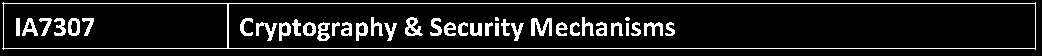

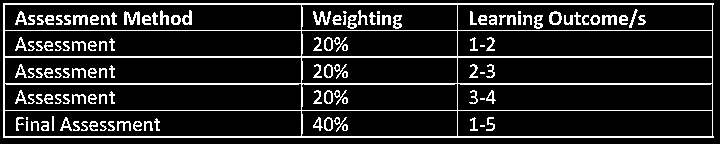

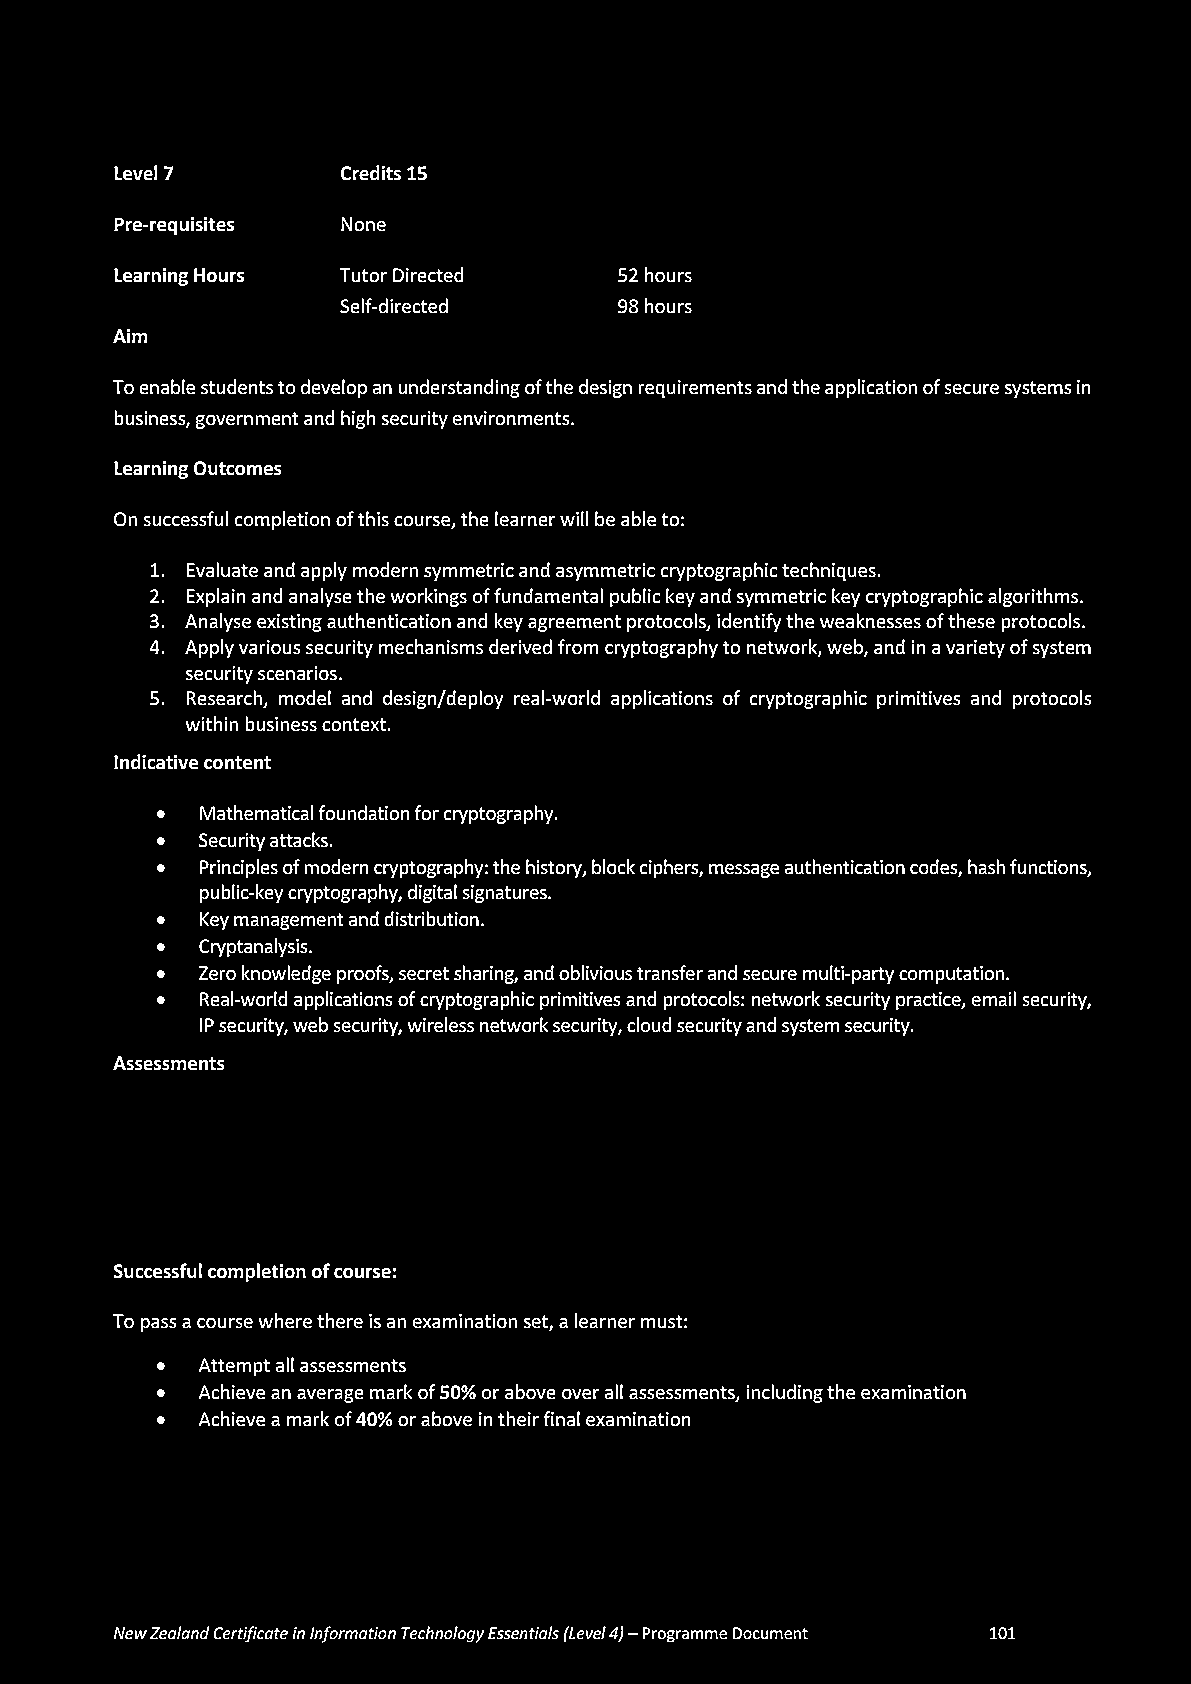

In [ ]:
# Temporary Parameters
tmpImgPaath = '/content/gdrive/MyDrive/OWR/data/tmp_input/page_101.png'

# Read the image
tmpImg = cv2.imread(tmpImgPaath)

binaryImg = getBinarized(tmpImg)

outer_rectangles, child_contours = getContours(binaryImg)

img1 = getTableImg(binaryImg, outer_rectangles, extract=1)
img2 = getTableImg(binaryImg, outer_rectangles, extract=2)
img3 = getTableImg(binaryImg, outer_rectangles, extract=-1)

cv2_imshow(img1)
cv2_imshow(img2)
cv2_imshow(img3)


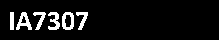

In [ ]:
img = imgCourseCode(img1, outer_rectangles, child_contours)
cv2_imshow(img)

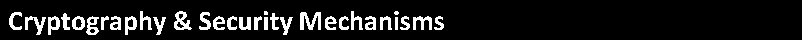

In [ ]:
img = imgCourseTitle(img1, outer_rectangles, child_contours)
cv2_imshow(img)


In [ ]:
imgChild1, imgChild2, imgChild3 = imgAssessments(img2, outer_rectangles, child_contours, 5)
cv2_imshow(imgChild1)
cv2_imshow(imgChild2)
cv2_imshow(imgChild3)


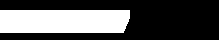

In [ ]:
Lines = getLines(img)

In [ ]:
Lines

[(0, 10, 130, 33)]

In [ ]:
img = img[Lines[0][1]:Lines[0][3], Lines[0][0]:Lines[0][2]]
cv2_imshow(img)

In [ ]:
words = getWords(img, Lines, 1)

In [ ]:
words

[[8, 10, 91, 33]]

In [ ]:
# Remove overlapping rectangles
non_overlapping_coordinates = remove_overlapping(words)

In [ ]:
non_overlapping_coordinates

[[8, 10, 91, 33]]

In [ ]:
for word in non_overlapping_coordinates:
  img_word = img[word[1]:word[3], word[0]:word[2]]
  #print(img_word)
  result_image = cv2.bitwise_not(img_word)
  cv2_imshow(result_image)


In [ ]:
word = non_overlapping_coordinates[0]
imgWord = img[word[1]:word[3], word[0]:word[2]]
cv2_imshow(imgWord)

non_overlapping_characters = getCharacters(imgWord, True)

print(non_overlapping_characters)

[[2, 6], [8, 24], [25, 38], [40, 52], [54, 66], [68, 80]]


In [ ]:
model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model4/model_ocr_v4_1.h5'

model, class_names, num_classes = load_character_prediction_model(model_path)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 31, 31, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 27, 27, 64)        204864    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 9, 13, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 11, 64)         36928     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 2, 3, 64)         

I


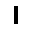

A


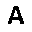

7


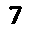

3


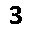

Q


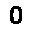

7


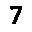

In [ ]:
# Draw the vertical lines
for i, x in enumerate(non_overlapping_characters):
    # Crop the character from the original image
    x1, x2 = x
    char_image = imgWord[: ,  x1 - 1:x2 + 1]

    # Create a blank white canvas (32x32)
    canvas = np.zeros((32, 32), dtype=np.uint8)

    # Calculate the position to paste the image onto the center of the canvas
    x_offset = (canvas.shape[1] - char_image.shape[1]) // 2
    y_offset = (canvas.shape[0] - char_image.shape[0]) // 2

    # Paste the image onto the canvas
    canvas[y_offset:y_offset + char_image.shape[0], x_offset:x_offset + char_image.shape[1]] = char_image

    canvas = cv2.bitwise_not(canvas)


    char = findCharacter(model, class_names, canvas)
    print(char)

    cv2_imshow(canvas)

In [ ]:
word_model_path = '/content/gdrive/MyDrive/OWR/dl_models/OWR_Model/Best_Img_recog_LSTM_Adam_model_run_weights.h5'

word_model = WM.Image_text_recogniser_model_1('predict')

word_model.load_weights(word_model_path)

word_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 170, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 170, 32, 64)       640       
                                                                 
 batch_normalization_14 (Ba  (None, 170, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_14 (Activation)  (None, 170, 32, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 85, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 85, 16, 128)       73856     
                                                           

In [ ]:
for word in non_overlapping_coordinates:
  img_word = img[word[1]:word[3], word[0]:word[2]]
  #print(img_word)
  result_image = cv2.bitwise_not(img_word)
  predict_word = findWord(word_model, result_image)
  print(predict_word)
  cv2_imshow(result_image)

1/1 [==============================] - 0s 151ms/step
IA7BO7
